#### Imports

In [1]:
%%javascript
utils.load_extension("collapsible_headings/main")
utils.load_extension("execute_time/ExecuteTime")

<IPython.core.display.Javascript object>

In [27]:
import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.estimator_checks import check_estimator
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
from tqdm.notebook import tqdm

import random

random.seed(0)

from make_data import make_movement_data,movement_equation
from CinematicEstimator import CinematicRegressor, CinematicClassifier

import warnings

warnings.filterwarnings("ignore")

## Create data

In [3]:
G = 100
data = make_movement_data(samples=1_000)
test = make_movement_data(samples=1_000)

X = data.drop(columns="pos")
y = data.pos

threshold = np.mean(y)
y_c = [1 if a_ > threshold else 0 for a_ in y]

X_test = test.drop(columns="pos")
y_test = test.pos
y_test_c = [1 if a_ > threshold else 0 for a_ in y_test]

## ML model
This should be replaced by using the Newton´s direct formula as an estimator

In [4]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [5]:
print(
    "100.000* Random Forest MSError", np.mean((rf.predict(X_test) - y_test) ** 2)/1_000_00
)

100.000* Random Forest MSError 3.1024706674206493e-07


In [6]:
print("100.000* MSError when predicting the mean", np.mean((y.mean() - y_test) ** 2)/1_000_00)

100.000* MSError when predicting the mean 1.6720871262953262e-05


## Newton Model

### Regressor

In [7]:
cr = CinematicRegressor()
cr.fit(X, y)

print("CinematicRegressor MSError", np.mean((cr.predict(X_test) - y_test) ** 2))

print("MSError when predicting the mean", np.mean((y.mean() - test.pos) ** 2))

CinematicRegressor MSError 0.0
MSError when predicting the mean 1.672087126295326


### Classifier

In [8]:
cc = CinematicClassifier(threshold=np.mean(y))

cc.fit(X, y)

CinematicClassifier(threshold=5.516770839789594)

In [9]:
print("Classification baseline")
print(classification_report(y_c, np.ones_like(y_c)))

Classification baseline
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       545
           1       0.46      1.00      0.63       455

    accuracy                           0.46      1000
   macro avg       0.23      0.50      0.31      1000
weighted avg       0.21      0.46      0.28      1000



In [10]:
print("Newton classifier")
print(classification_report(y_c, cc.predict(X)))

Newton classifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       545
           1       1.00      1.00      1.00       455

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



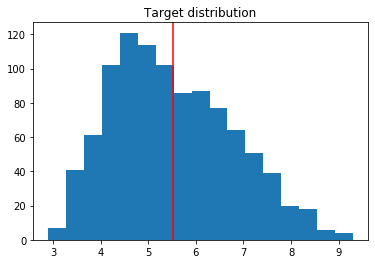

In [11]:
plt.figure()
plt.title("Target distribution")
plt.hist(y, bins="auto")
plt.axvline(x=np.mean(y), ymin=0, ymax=350, c="r")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff903ce73d0>]],
      dtype=object)

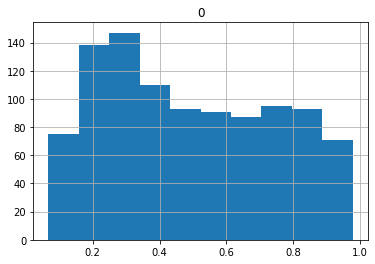

In [12]:
pd.DataFrame(np.array(cc.predict_proba(X))).hist()

In [13]:
# check_estimator(NewtonClassifier())

## Explainability

### Lime

#### Lime Regressor

In [14]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X.values, feature_names=X.columns, verbose=False, mode="regression",
)

In [15]:
for i in range(0, 5):
    i = np.random.randint(low=0, high=X.shape[0])
    exp = explainer.explain_instance(X.iloc[i], cr.predict, num_features=5)

    exp.show_in_notebook(show_table=True)

### Lime classifier

## Shap

In [16]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()


# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(cc.predict_proba, X, link="logit")
shap_values = explainer.shap_values(X, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(
    explainer.expected_value[0], shap_values[0][0, :], X_test.iloc[0, :], link="logit"
)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [17]:
shap.force_plot(
    explainer.expected_value[0], np.nan_to_num(shap_values[0]), X, link="logit"
)

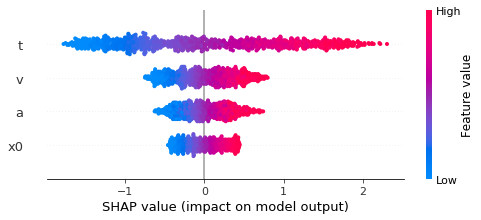

In [18]:
shap.summary_plot(shap_values[0], X.iloc[0:1000,:])

## Decision boundaries

### Classification

In [33]:
X.head(1)

x0         v         a         t
0  1.718636  1.404775  1.854035  1.974607

In [42]:
def f(m, q):
    out = np.zeros([len(m), len(q)])

    for i in tqdm(range(0, len(m)), desc=" outer", position=0,):
        for j in range(0, len(q)):
            out[i][j] = (
                cc.predict_proba(np.array([1, 1,m[i], q[j]]).reshape(1, -1))
                .squeeze()
                .item()
            )
    return out

In [43]:
m1_min=0.001,
m1_max=1,
m2_min=0.001,
m2_max=1,
r_min=1,
r_max=10,

In [44]:
M = np.linspace(0,1, 100)
Q = np.linspace(1, 10, 100)
Z = f(M, Q)
M, Q = np.meshgrid(M, Q)

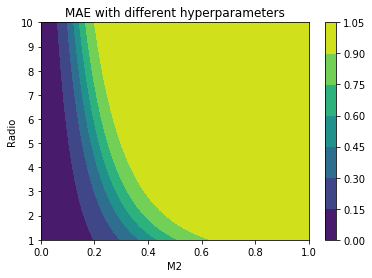

In [45]:
plt.plot()
cp = plt.contourf(M, Q, Z)
plt.colorbar(cp)  #Add a colorbar to a plot
plt.xlabel('M2')
plt.ylabel('Radio')
plt.title('Predictions with different hyperparameters')
plt.savefig('hyperparameters_contour.eps',format='eps')
plt.show()

### Regression

In [46]:
def f(m, q):
    out = np.zeros([len(m), len(q)])

    for i in tqdm(range(0, len(m)), desc=" outer", position=0,):
        for j in range(0, len(q)):
            out[i][j] = (
                cr.predict(np.array([1, 1,m[i], q[j]]).reshape(1, -1)).squeeze().item()
            )
    return out

In [47]:
M = np.linspace(0, 1, 100)
Q = np.linspace(1, 10, 100)
Z = f(M, Q)
M, Q = np.meshgrid(M, Q)

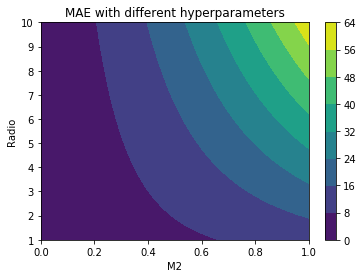

In [48]:
plt.plot()
cp = plt.contourf(M, Q, Z)
plt.colorbar(cp)  # Add a colorbar to a plot
plt.xlabel("M2")
plt.ylabel("Radio")
plt.title("Predictions with different hyperparameters")
plt.savefig("hyperparameters_contour.eps", format="eps")
plt.show()